### 1 camera calibration

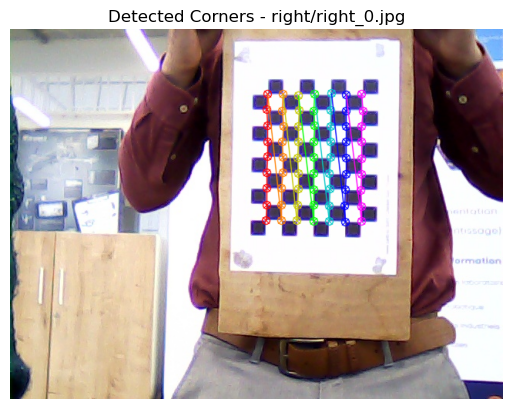

Saved: output_corners\right_0.jpg


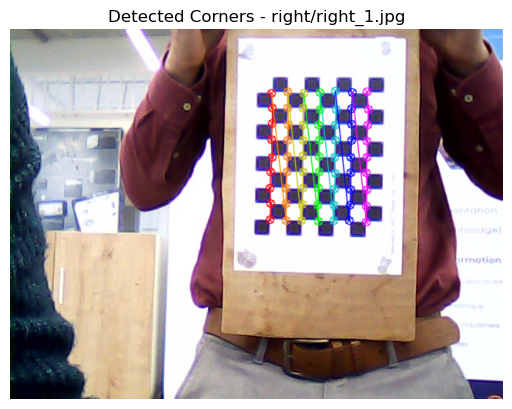

Saved: output_corners\right_1.jpg


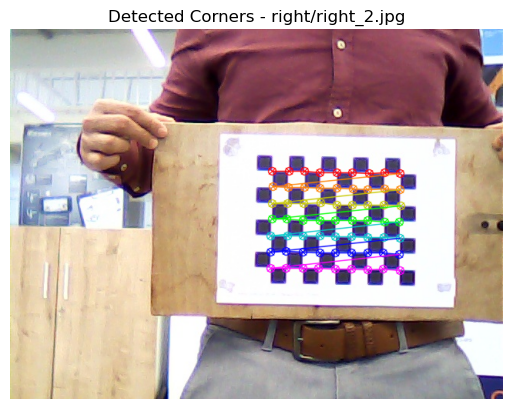

Saved: output_corners\right_2.jpg


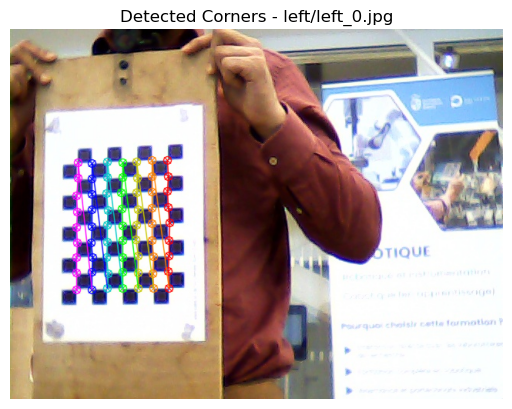

Saved: output_corners\left_0.jpg


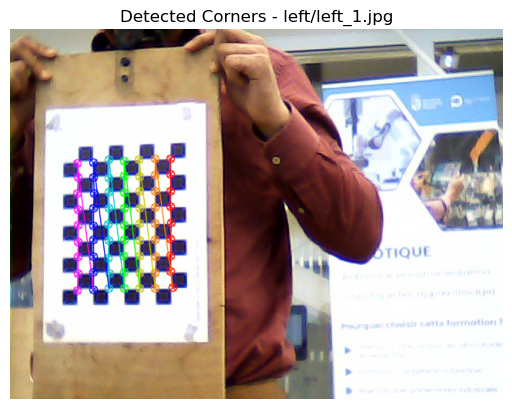

Saved: output_corners\left_1.jpg


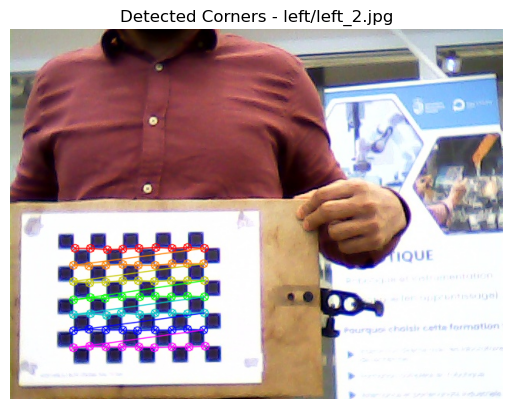

Saved: output_corners\left_2.jpg


In [3]:
 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define chessboard size (Adjust if necessary)
chessboard_size = (9,7 )  # (Columns, Rows) - Change if needed
square_size = 1.0  # Set to 1.0 if unknown

# Prepare object points (3D points of chessboard corners in real-world)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * square_size

# Lists to store 3D points (object points) and 2D points (image points)
objpoints = []  # Real-world points
imgpoints = []  # Image points (detected corners)

# List of calibration images (PNG format)
image_paths = ["right/right_0.jpg","right/right_1.jpg","right/right_2.jpg","left/left_0.jpg","left/left_1.jpg","left/left_2.jpg"]

# Create a folder to save output images
output_folder = "output_corners"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Read and process each calibration image
for img_path in image_paths:
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Error: Could not load {img_path}")
        continue
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    
    # Detect chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Corners - {img_path}")
        plt.axis("off")
        plt.show()

        # Save the output image with detected corners
        output_path = os.path.join(output_folder, os.path.basename(img_path))
        cv2.imwrite(output_path, img)
        print(f"Saved: {output_path}")
    else:
        print(f"Chessboard not detected in {img_path}")
  


# 2. Compute Intrinsic Parameters

In [5]:
# Performed camera calibration
if len(objpoints) > 0 and len(imgpoints) > 0:
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    print("Intrinsic Matrix (K):\n", K)
    print("\nDistortion Coefficients:\n", dist)

    # Computed reprojection error
    reprojection_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        reprojection_error += error
    reprojection_error /= len(objpoints)

    print("\nReprojection Error:", reprojection_error)

else:
    print("Calibration failed: No valid chessboard detections.")


Intrinsic Matrix (K):
 [[2.02000903e+03 0.00000000e+00 2.91857478e+02]
 [0.00000000e+00 1.99604747e+03 1.84051507e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [[-1.37466838e+00  1.30448239e+02  4.93230830e-03  7.08938060e-03
  -3.39547959e+03]]

Reprojection Error: 0.11086367915593026


# 3. Undistort Images

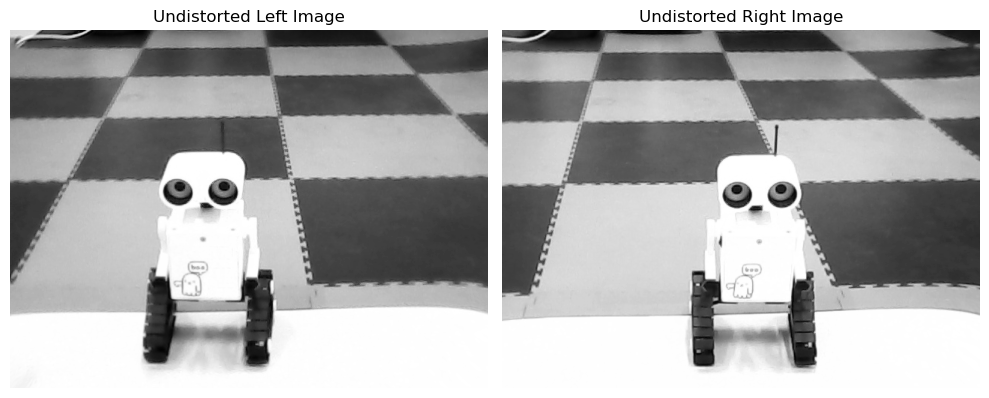

Undistorted images saved to: undistorted_output


In [9]:

# Define paths
input_left_path = "left/left_5.jpg"
input_right_path = "right/right_5.jpg"
output_folder = "undistorted_output"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load left and right images
left_img = cv2.imread("left/left_5.jpg")
right_img = cv2.imread("right/right_5.jpg")

# Check if images are loaded successfully
if left_img is None or right_img is None:
    raise FileNotFoundError("One or both images could not be loaded. Check the file paths.")

# Convert images to grayscale
left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

# Undistort images using camera matrix (K) and distortion coefficients (dist)
undistorted_left = cv2.undistort(left_gray, K, dist)
undistorted_right = cv2.undistort(right_gray, K, dist)

# Save undistorted images to the output folder
output_left_path = os.path.join(output_folder, "undistorted_left.jpg")
output_right_path = os.path.join(output_folder, "undistorted_right.jpg")
cv2.imwrite(output_left_path, undistorted_left)
cv2.imwrite(output_right_path, undistorted_right)

# Display the undistorted images side by side
plt.figure(figsize=(10, 5))

# Display left undistorted image
plt.subplot(1, 2, 1)
plt.imshow(undistorted_left, cmap="gray")
plt.title("Undistorted Left Image")
plt.axis("off")

# Display right undistorted image
plt.subplot(1, 2, 2)
plt.imshow(undistorted_right, cmap="gray")
plt.title("Undistorted Right Image")
plt.axis("off")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

print(f"Undistorted images saved to: {output_folder}")

# 4. Feature Matching using SIFT

Total number of matching features: 94
Feature matching image saved as sift_matches.png


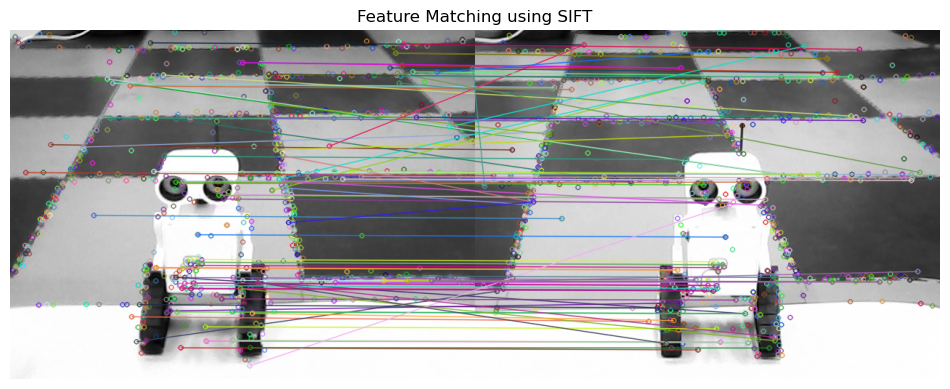

In [12]:

# Detect and compute SIFT keypoints
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(undistorted_left, None)
kp2, des2 = sift.detectAndCompute(undistorted_right, None)

# Feature Matching using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Print the total number of matching features
total_matches = len(good_matches)
print(f"Total number of matching features: {total_matches}")

# Draw matches
matched_img = cv2.drawMatches(undistorted_left, kp1, undistorted_right, kp2, good_matches, None)

# Save the output image
output_path = "sift_matches.png"
cv2.imwrite(output_path, matched_img)
print(f"Feature matching image saved as {output_path}")

# Show matched features
plt.figure(figsize=(12, 6))
plt.imshow(matched_img)
plt.title("Feature Matching using SIFT")
plt.axis("off")
plt.show()

In [14]:
# Extract matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Compute Fundamental Matrix with RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

print("Fundamental Matrix (F):\n", F)


Fundamental Matrix (F):
 [[-1.00643835e-06  5.48731192e-04 -3.51752859e-01]
 [-6.07615711e-04 -8.13760078e-04 -7.32773356e+00]
 [ 3.69606100e-01  7.71305538e+00  1.00000000e+00]]


In [16]:
# Compute Essential Matrix
E, _ = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC)

# Recover the Camera Pose
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

print("Essential Matrix (E):\n", E)
print("\nRotation Matrix (R):\n", R)
print("\nTranslation Vector (t):\n", t)


Essential Matrix (E):
 [[ 0.00179723  0.06764267  0.01550432]
 [ 0.01353414 -0.00342982  0.70680383]
 [-0.01562246 -0.70368137 -0.00165178]]

Rotation Matrix (R):
 [[ 9.93385052e-01 -7.34291854e-05 -1.14830891e-01]
 [ 6.33444631e-04  9.99988085e-01  4.84038842e-03]
 [ 1.14829168e-01 -4.88110851e-03  9.93373262e-01]]

Translation Vector (t):
 [[ 0.99516919]
 [-0.02160604]
 [ 0.09576778]]


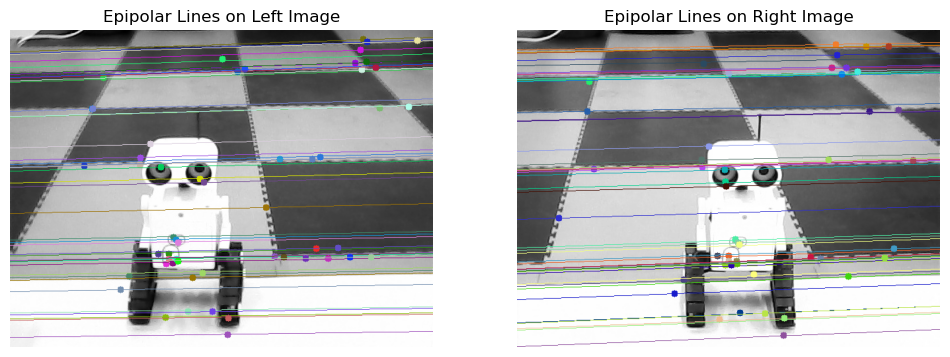

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
left_img = cv2.imread("left/left_5.jpg", cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread("right/right_5.jpg", cv2.IMREAD_GRAYSCALE)

# Detect and compute SIFT keypoints
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left_img, None)
kp2, des2 = sift.detectAndCompute(right_img, None)

# Feature Matching using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

# Extract matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Compute the Fundamental Matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select only inliers
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Compute epipolar lines
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

def draw_epilines(img, lines, pts):
    """Draws epipolar lines on an image."""
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    r, c = img.shape[:2]
    for r, pt in zip(lines, pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])  # Line intersection with left border
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])  # Line intersection with right border
        cv2.line(img_color, (x0, y0), (x1, y1), color, 1)
        cv2.circle(img_color, tuple(pt.astype(int)), 5, color, -1)
    return img_color

# Draw epipolar lines
left_with_lines = draw_epilines(left_img, lines1, pts1)
right_with_lines = draw_epilines(right_img, lines2, pts2)

# Show the results
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(left_with_lines)
plt.title("Epipolar Lines on Left Image"), plt.axis("off")
plt.subplot(122), plt.imshow(right_with_lines)
plt.title("Epipolar Lines on Right Image"), plt.axis("off")
plt.show()



In [20]:
# Projection matrices
P1 = np.dot(K, np.hstack((np.eye(3), np.zeros((3, 1)))))  # Camera 1
P2 = np.dot(K, np.hstack((R, t)))  # Camera 2

# Perform triangulation
points_4D = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
points_3D = points_4D[:3] / points_4D[3]  # Convert from homogeneous to 3D coordinates

print("Triangulated 3D Points:\n", points_3D.T)


Triangulated 3D Points:
 [[-7.56571710e-01  9.76863429e-02  8.50055981e+00]
 [-7.78440595e-01 -3.01429451e-01  9.42091942e+00]
 [-7.78300345e-01 -3.01720530e-01  9.42695141e+00]
 [-7.46420026e-01 -5.54507256e-01  1.00594110e+01]
 [-4.09352809e-01  7.03092933e-01  6.64799166e+00]
 [-3.64994496e-01  6.34645522e-01  6.64810562e+00]
 [-2.99653083e-01  6.67141676e-02  6.37804985e+00]
 [-2.98762619e-01  3.33894603e-02  6.42394209e+00]
 [-2.56310880e-01 -3.27246897e-02  6.48742151e+00]
 [-2.16703504e-01  5.04343510e-01  6.45634222e+00]
 [-1.99712157e-01  8.00729319e-02  6.32648468e+00]
 [-1.86319456e-01  8.37800145e-01  6.63044882e+00]
 [-1.76899955e-01  5.53164244e-01  6.48359823e+00]
 [-1.64042786e-01  5.02307117e-01  6.44239950e+00]
 [-1.63953424e-01  5.29030859e-01  6.45927906e+00]
 [-1.46919772e-01  5.51757216e-01  6.47589111e+00]
 [-1.39583156e-01  4.19627190e-01  6.38521576e+00]
 [-1.26922667e-01  4.33308363e-01  6.39808226e+00]
 [-1.25657946e-01  5.30346572e-01  6.45567894e+00]
 [-1.1

In [22]:
import open3d as o3d

# Convert triangulated 3D points into Open3D point cloud format
points_3D = points_3D.T  # Transpose to (N,3) format
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points_3D)

# Save the 3D point cloud to a file
output_path = "point_cloud.ply"
o3d.io.write_point_cloud(output_path, point_cloud)
print(f"3D point cloud saved as {output_path}")

# Visualize the point cloud
o3d.visualization.draw_geometries([point_cloud])



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
3D point cloud saved as point_cloud.ply
